# Predictiong and Analysis of Inflation

Hi,

My name is Leon, and this is my Analysis of inflation project.

In the project below I am going to analyze relationship between different inflation metrics, as well as predict price inflation.  

In the older days, the definition of inflation was increase of monetary supply, which devalues the currency.  
However in modern days by inflation what is meant usually in increase in prices, which also means devaluation of the currency, but in a different way.  

For the monetary supply index I will use M1 for this notebook.  
For the price index I will use CPI index,

In the nootebook below I am going to analyze the relationship between M1 and CPI as well as those indices individually.  

The final goal of the notebook is to build a model to predict CPI inflation index by data including the M1.

## Data description

### Monetary supply

There are various indices for measuring how much money exists in the economy:  
M0, M1, M2, M3, M4  
Basically the difference between them is what is considered as money in the index and what is not,  
For example M0 index is used to measure the amount of all banknotes and coins, and M1 adds checkable deposits (a type of credit) on top of that.  
each subsequent index includes more asset classes on top of what the previous one includes.  
More information on the indices:  
https://www.wallstreetmojo.com/money-supply/

All the data is available on the [Federal Reserve website](https://fred.stlouisfed.org/).  
We'll use the following dataset as it is not adjusted to inflation:  
https://fred.stlouisfed.org/series/M1NS 

### Prices increases

For the data for increases in prices we'll choose CPI (Consumer Price Index),  
It is calculated by the [U.S. BUREAU OF LABOR STATISTICS](https://www.bls.gov/).  
In short, it measures the cost of various specific goods that are consumed by everyday people.
Although this index is far from perfect for many reasons,  
It is still the most common index of prices inflation.  
More information on the CPI and how it is measured:  
https://www.investopedia.com/terms/c/consumerpriceindex.asp   

The data can be downloaded from the BLS website:  
https://www.bls.gov/cpi/data.htm

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import datetime

# Model packages
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

# preprocessing libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.utils import resample
from numpy.random import RandomState
import warnings
from IPython.display import clear_output


# Evaluation
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
# import keras
# from keras.layers import *
# import tensorflow as tf

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score


# from keras.optimizers import RMSprop

from random import seed
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.ticker as mtick

## Loading datasets

The data is very small, as each dataset consists of just a single datapoint for every month for several decades.  
So all the data was already downloaded and saved locally to small excel files in this repository.

### CPI

In [2]:
df_cpi_raw = pd.read_excel('cpi data.xlsx', skiprows=11)

In [3]:
df_cpi_raw.sample(3)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
86,1999.0,164.3,164.5,165.0,166.2,166.2,166.2,166.7,167.1,167.9,168.2,168.3,168.3,165.4,167.8
49,1962.0,30.0,30.1,30.1,30.2,30.2,30.2,30.3,30.3,30.4,30.4,30.4,30.4,NaN,NaN
14,1927.0,17.5,17.4,17.3,17.3,17.4,17.6,17.3,17.2,17.3,17.4,17.3,17.3,NaN,NaN


### M1

In [5]:
df_m1_raw = pd.read_excel('M1NS.xls', skiprows=10)

In [6]:
df_m1_raw.sample(3)

,observation_date,M1NS
129,1969-10-01,202.9
331,1986-08-01,678.4
133,1970-02-01,202.0


### M2

In [7]:
df_m2_raw = pd.read_excel('M2NS.xls', skiprows=10)

In [8]:
df_m2_raw.sample(3)

,observation_date,M2NS
283,1982-08-01,1845.9
184,1974-05-01,873.4
523,2002-08-01,5621.7


Looks like M1 and M2 data dataset are already stored in convenient Time Series format,  
But We'll need to transform the CPI data to match the other datasets.

## Checking Data integrity

### CPI

In [9]:
df_cpi_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    110 non-null    float64
 1   Jan     110 non-null    float64
 2   Feb     110 non-null    float64
 3   Mar     110 non-null    float64
 4   Apr     110 non-null    float64
 5   May     110 non-null    float64
 6   Jun     110 non-null    float64
 7   Jul     110 non-null    float64
 8   Aug     110 non-null    float64
 9   Sep     109 non-null    float64
 10  Oct     109 non-null    float64
 11  Nov     109 non-null    float64
 12  Dec     109 non-null    float64
 13  HALF1   39 non-null     float64
 14  HALF2   38 non-null     float64
dtypes: float64(15)
memory usage: 13.0 KB


In [10]:
df_cpi_raw.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
0,1913.0,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,NaN,NaN
1,1914.0,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,NaN,NaN
2,1915.0,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,NaN,NaN
3,1916.0,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,NaN,NaN
4,1917.0,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,NaN,NaN


We see 2 definetely excess columns here: HALF1, HALF2.  
Better get rid of them now.

In [11]:
df_cpi_raw = df_cpi_raw.drop(["HALF1", "HALF2"], axis=1)

### M1

In [12]:
df_m1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  764 non-null    datetime64[ns]
 1   M1NS              764 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 KB


In [13]:
df_m1_raw.head(10)

,observation_date,M1NS
0,1959-01-01,142.2
1,1959-02-01,139.3
2,1959-03-01,138.4
3,1959-04-01,139.7
4,1959-05-01,138.7
5,1959-06-01,139.4
6,1959-07-01,140.3
7,1959-08-01,140.0
8,1959-09-01,140.3
9,1959-10-01,140.7


In [14]:
df_m1_raw.shape

(764, 2)

The data here is already in the format I want to be, so there won't be much of data transformation on this dataframe.

In [10]:
df_m1_raw = df_m1_raw.rename(columns={
    'observation_date' : 'month',
    'M1NS' : 'M1'})

In [11]:
df_m2_raw.sample(3)

,observation_date,M2NS
650,2013-03-01,10626.9
352,1988-05-01,2910.7
361,1989-02-01,2982.6


In [18]:
df_m2_raw = df_m2_raw.rename(columns={
    'observation_date' : 'month',
    'M2NS' : 'M2'})

## Preprocessing

In [20]:
df_inflation = df_m1_raw.copy()

In [21]:
df_inflation

,month,M1
0,1959-01-01,142.2
1,1959-02-01,139.3
2,1959-03-01,138.4
3,1959-04-01,139.7
4,1959-05-01,138.7
...,...,...
759,2022-04-01,20817.8
760,2022-05-01,20537.9
761,2022-06-01,20535.4
762,2022-07-01,20471.7


In [22]:
df_cpi_raw = df_cpi_raw.melt(id_vars=["Year"]).sort_values(by="Year")

In [23]:
df_cpi_raw.head(15)

,Year,variable,value
0,1913.0,Jan,9.8
330,1913.0,Apr,9.8
550,1913.0,Jun,9.8
660,1913.0,Jul,9.9
220,1913.0,Mar,9.8
770,1913.0,Aug,9.9
1210,1913.0,Dec,10.0
880,1913.0,Sep,10.0
110,1913.0,Feb,9.8
990,1913.0,Oct,10.0


I'll just rename month to a normal feature name,
I call it **month_raw** as I want to use month afterwards for the full month format

In [24]:
df_cpi_raw = df_cpi_raw.rename(columns={
    'variable' : 'month_raw',
    'value' : 'CPI'})

In [25]:
# df_cpi_raw = df_cpi_raw.query('month_raw not in ["HALF1", "HALF2"]')

In [26]:
df_cpi_raw.head(15)

,Year,month_raw,CPI
0,1913.0,Jan,9.8
330,1913.0,Apr,9.8
550,1913.0,Jun,9.8
660,1913.0,Jul,9.9
220,1913.0,Mar,9.8
770,1913.0,Aug,9.9
1210,1913.0,Dec,10.0
880,1913.0,Sep,10.0
110,1913.0,Feb,9.8
990,1913.0,Oct,10.0


In [27]:
df_cpi_raw['Year'] = df_cpi_raw['Year'].astype('int')

In [28]:
df_cpi_raw['month'] = pd.to_datetime(df_cpi_raw['month_raw'] + ' ' + df_cpi_raw['Year'].astype('str'))

In [29]:
df_cpi_raw = df_cpi_raw.sort_values(by='month')

In [30]:
# df_cpi_index_montly = df_cpi_raw.copy()

In [31]:
# df_cpi_index_montly

In [32]:
# df_cpi_index_montly['month'] = pd.to_datetime(df_cpi_index_montly['month_raw'] + ' ' + df_cpi_index_montly['Year'].astype('str'))

In [33]:
# df_cpi_index_montly

In [34]:
# df_cpi_index_montly = df_cpi_index_montly[['month', 'CPI']]#.set_index('month')

In [35]:
# df_cpi_index_montly = df_cpi_index_montly.sort_values(by='month')#.set_index('month')

In [36]:
# df_inflation

In [37]:
# df_cpi_raw

In [38]:
df_inflation = df_inflation.merge(df_cpi_raw, on="month", how="outer")

In [39]:
df_inflation = df_inflation.merge(df_m2_raw, on="month", how="outer")

In [40]:
df_inflation

,month,M1,Year,month_raw,CPI,M2
0,1959-01-01,142.2,1959,Jan,29.0,289.8
1,1959-02-01,139.3,1959,Feb,28.9,287.7
2,1959-03-01,138.4,1959,Mar,28.9,287.9
3,1959-04-01,139.7,1959,Apr,29.0,290.2
4,1959-05-01,138.7,1959,May,29.0,290.2
...,...,...,...,...,...,...
1315,1958-12-01,NaN,1958,Dec,28.9,NaN
1316,2022-09-01,NaN,2022,Sep,NaN,NaN
1317,2022-10-01,NaN,2022,Oct,NaN,NaN
1318,2022-11-01,NaN,2022,Nov,NaN,NaN


In [41]:
df_inflation = df_inflation.sort_values(by='month').reset_index(drop=True)

In [42]:
df_inflation['cpi_monthy_change'] = df_inflation['CPI'].pct_change()
df_inflation['m1_monthy_change'] = df_inflation['M1'].pct_change()
df_inflation['m2_monthy_change'] = df_inflation['M2'].pct_change()
df_inflation['cpi_monthy_sma'] = df_inflation['cpi_monthy_change'].dropna().rolling(15).mean()
df_inflation['m1_monthy_sma'] = df_inflation['m1_monthy_change'].dropna().rolling(15).mean()
df_inflation['m2_monthy_sma'] = df_inflation['m2_monthy_change'].dropna().rolling(15).mean()

In [43]:
df_inflation['cpi_quarterly_change'] = df_inflation['CPI'].pct_change(periods=3)
df_inflation['m1_quarterly_change'] = df_inflation['M1'].pct_change(periods=3)
df_inflation['m2_quarterly_change'] = df_inflation['M2'].pct_change(periods=3)
df_inflation['cpi_quarterly_sma'] = df_inflation['cpi_quarterly_change'].rolling(15).mean()
df_inflation['m1_quarterly_sma'] = df_inflation['m1_quarterly_change'].rolling(15).mean()
df_inflation['m2_quarterly_sma'] = df_inflation['m2_quarterly_change'].rolling(15).mean()

In [44]:
df_inflation['cpi_half_year_change'] = df_inflation['CPI'].pct_change(periods=6)
df_inflation['m1_half_year_change'] = df_inflation['M1'].pct_change(periods=6)
df_inflation['m2_half_year_change'] = df_inflation['M2'].pct_change(periods=6)
df_inflation['cpi_half_year_sma'] = df_inflation['cpi_half_year_change'].rolling(15).mean()
df_inflation['m1_half_year_sma'] = df_inflation['m1_half_year_change'].rolling(15).mean()
df_inflation['m2_half_year_sma'] = df_inflation['m2_half_year_change'].rolling(15).mean()

In [45]:
df_inflation['cpi_yearly_change'] = df_inflation['CPI'].pct_change(periods=12)
df_inflation['m1_yearly_change'] = df_inflation['M1'].pct_change(periods=12)
df_inflation['m2_yearly_change'] = df_inflation['M2'].pct_change(periods=12)
df_inflation['cpi_yearly_sma'] = df_inflation['cpi_yearly_change'].rolling(15).mean()
df_inflation['m1_yearly_sma'] = df_inflation['m1_yearly_change'].rolling(15).mean()
df_inflation['m2_yearly_sma'] = df_inflation['m2_yearly_change'].rolling(15).mean()

<AxesSubplot:>

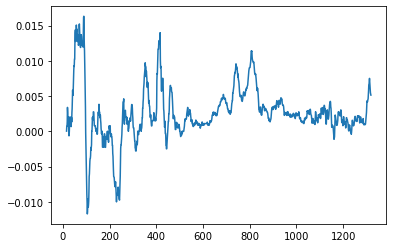

In [46]:
df_inflation['cpi_monthy_sma'].plot()

In [47]:
df_inflation

,month,M1,Year,month_raw,CPI,M2,cpi_monthy_change,m1_monthy_change,m2_monthy_change,cpi_monthy_sma,...,m2_half_year_change,cpi_half_year_sma,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma
0,1913-01-01,NaN,1913,Jan,9.800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1913-02-01,NaN,1913,Feb,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1913-03-01,NaN,1913,Mar,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1913-04-01,NaN,1913,Apr,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1913-05-01,NaN,1913,May,9.700,NaN,-0.010204,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2022-08-01,20380.2,2022,Aug,296.171,21625.3,-0.000354,-0.00447,-0.001247,0.006396,...,0.001612,0.041952,0.043250,0.038186,0.082627,0.035385,0.040779,0.072031,0.119461,0.100705
1316,2022-09-01,NaN,2022,Sep,NaN,NaN,0.000000,0.00000,0.000000,0.005777,...,-0.010546,0.041090,0.036847,0.033352,0.079695,0.025460,0.031845,0.073750,0.110013,0.094222
1317,2022-10-01,NaN,2022,Oct,NaN,NaN,0.000000,0.00000,0.000000,0.005456,...,-0.010750,0.039807,0.030379,0.028505,0.070798,0.017941,0.024993,0.074893,0.100409,0.087417
1318,2022-11-01,NaN,2022,Nov,NaN,NaN,0.000000,0.00000,0.000000,0.005319,...,0.001616,0.038016,0.024683,0.024331,0.065563,0.005566,0.013626,0.075763,0.089657,0.079378


## EDA

### CPI

#### Monthy Change

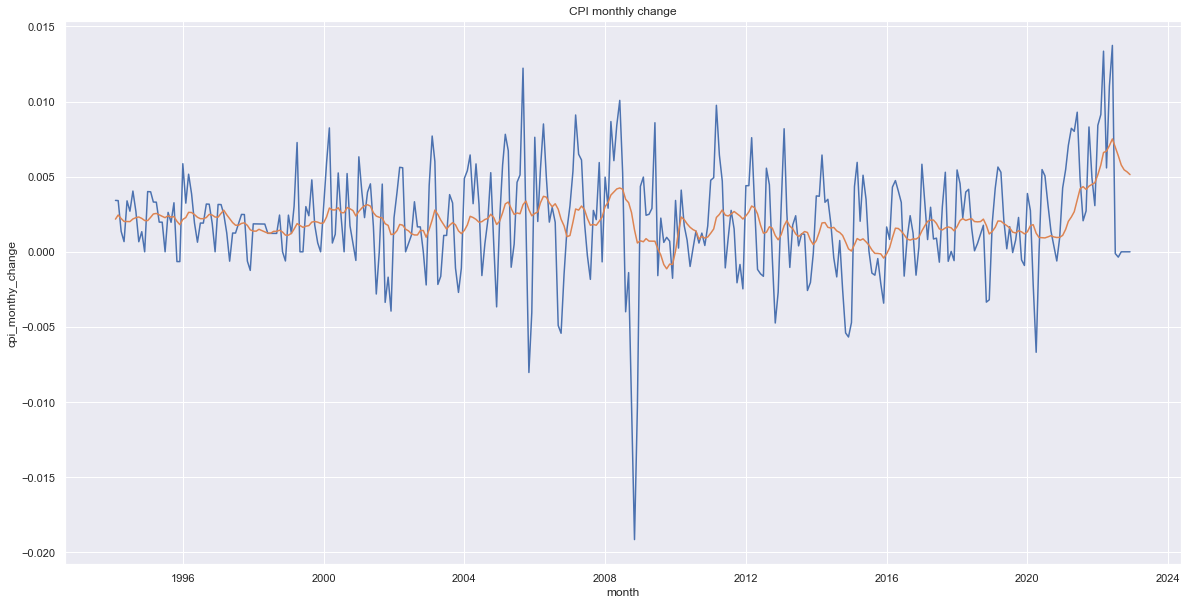

In [48]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="cpi_monthy_change")
sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="cpi_monthy_sma")
ax.set(title="CPI monthly change")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#### Quarterly change

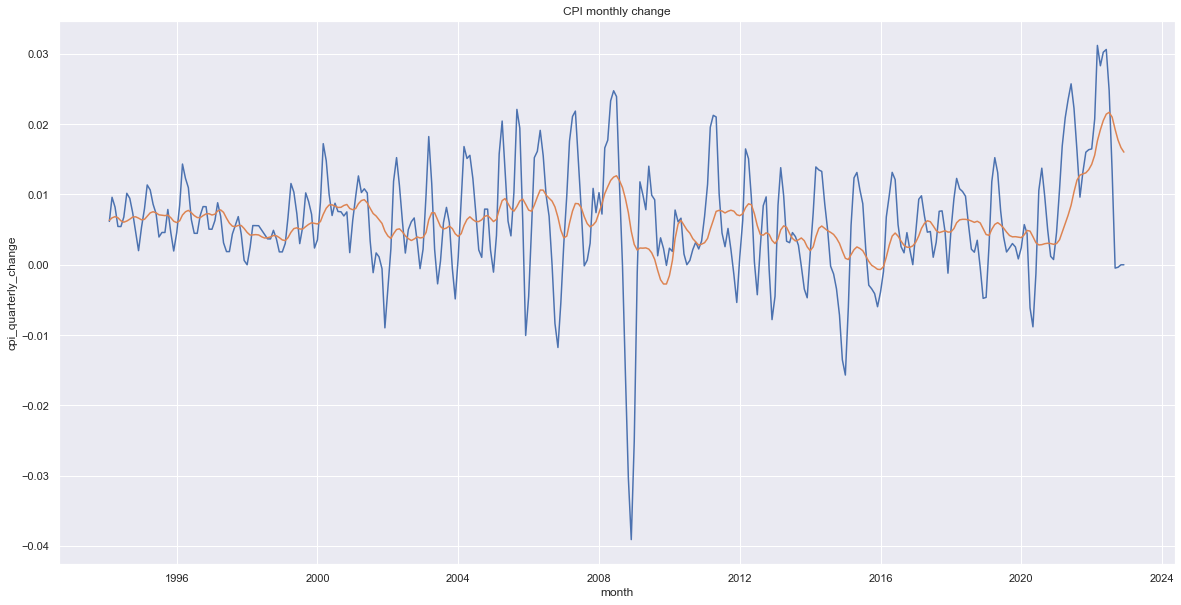

In [49]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="cpi_quarterly_change")
sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="cpi_quarterly_sma")
ax.set(title="CPI monthly change")
plt.show()

#### Half Yearly Change

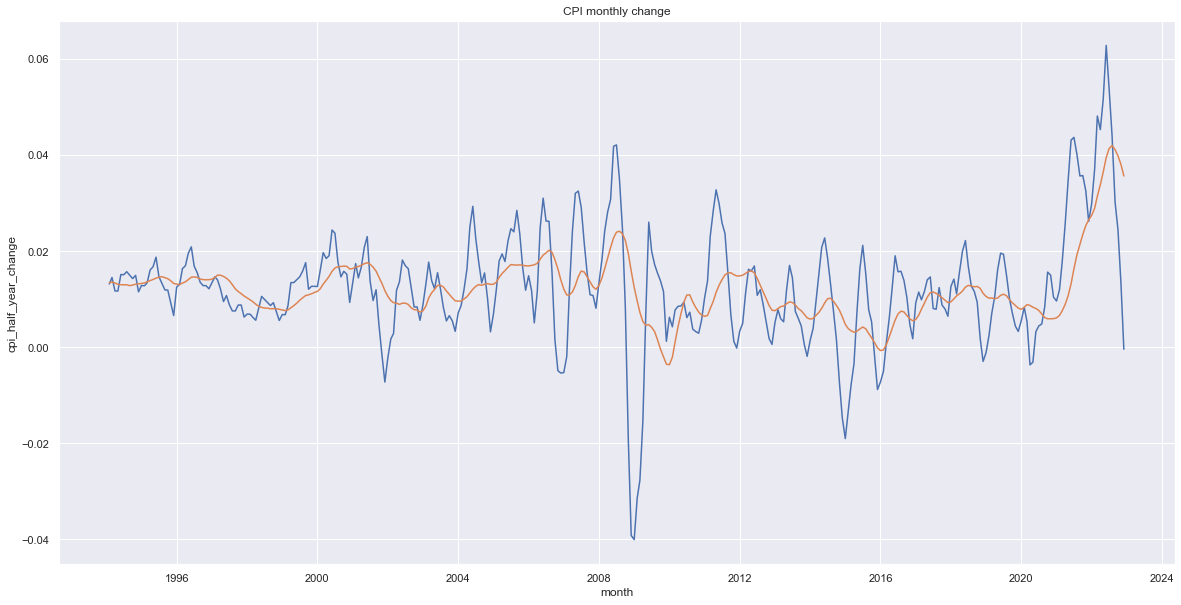

In [50]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="cpi_half_year_change")
sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="cpi_half_year_sma")
ax.set(title="CPI monthly change")
plt.show()

#### Yearly

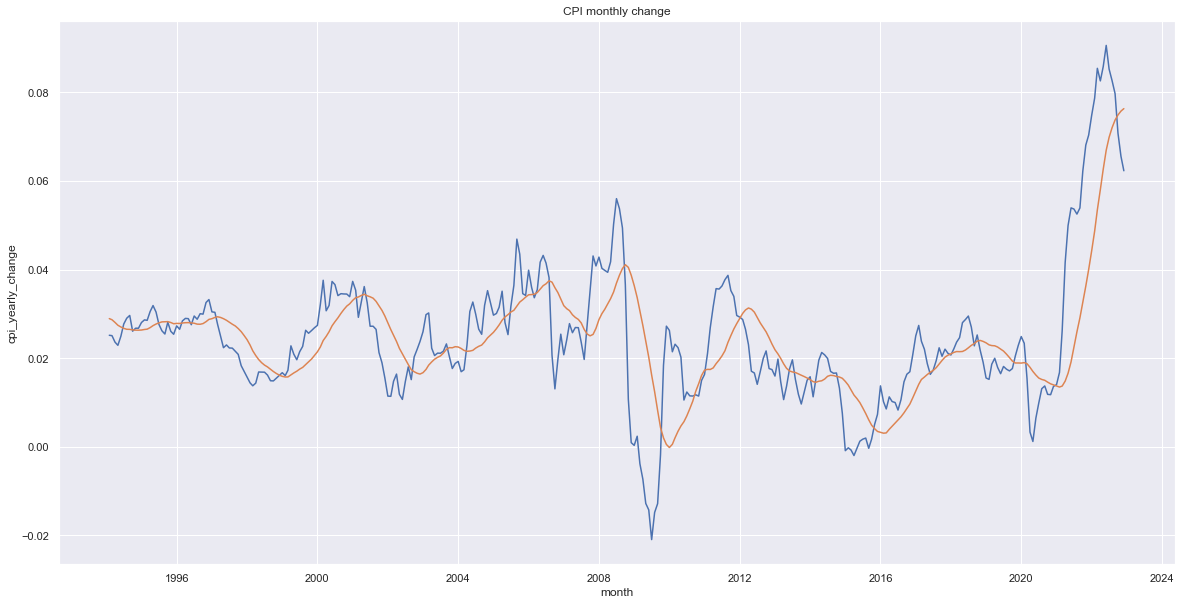

In [51]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="cpi_yearly_change")
sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="cpi_yearly_sma")
ax.set(title="CPI monthly change")
plt.show()

### M2

#### Monthy Change

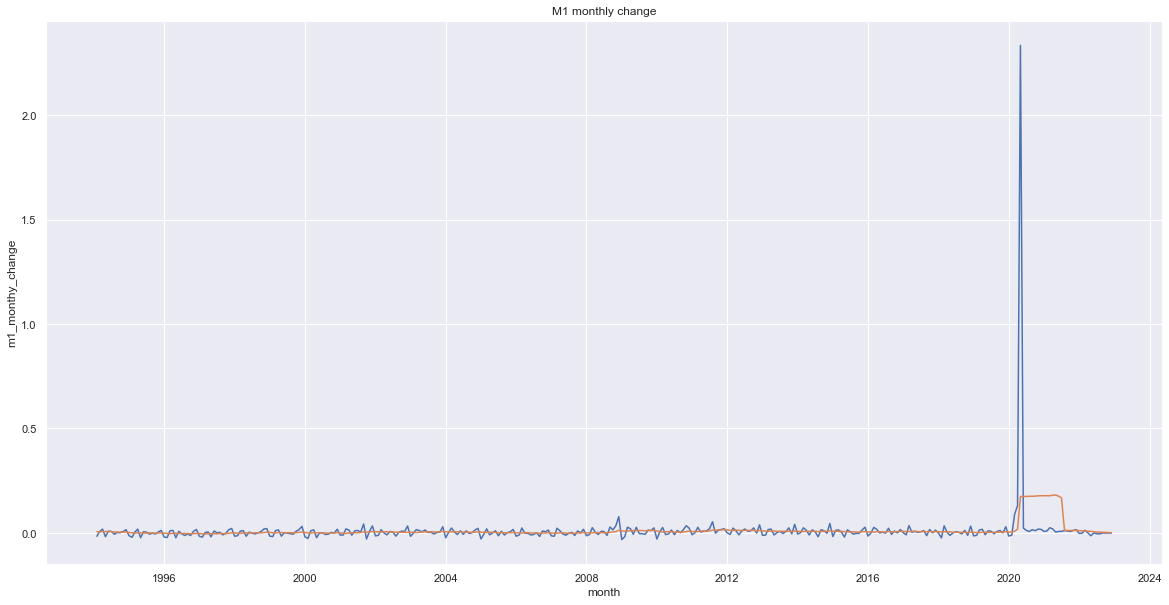

In [52]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="m1_monthy_change")
sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="m1_monthy_sma")
ax.set(title="M1 monthly change")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#### Quarterly change

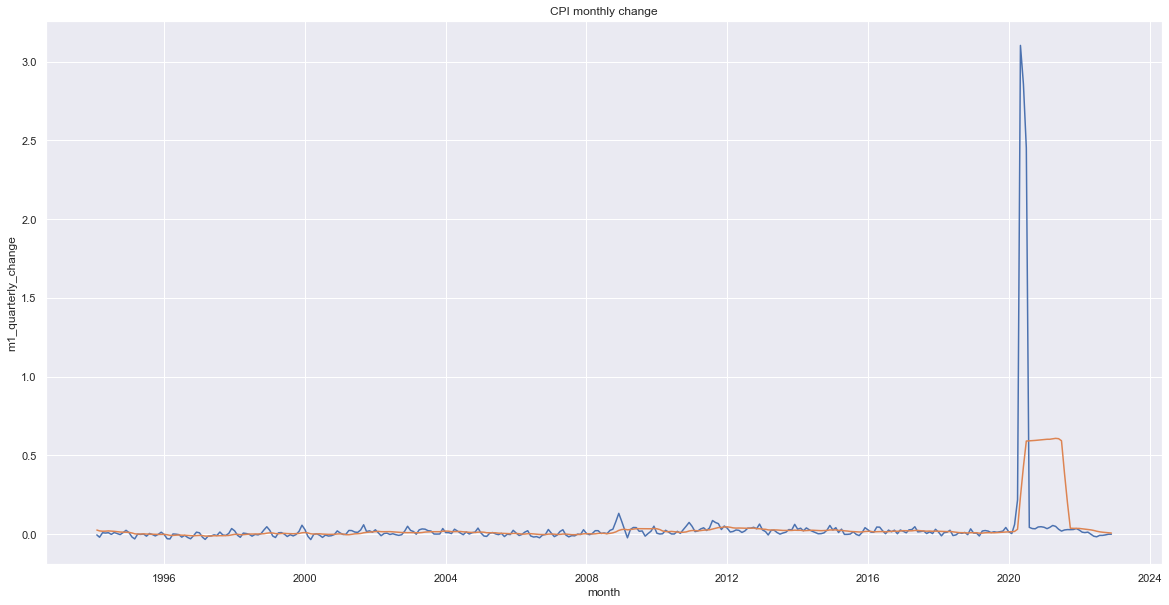

In [53]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="m1_quarterly_change")
sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="m1_quarterly_sma")
ax.set(title="CPI monthly change")
plt.show()

#### Half Yearly Change

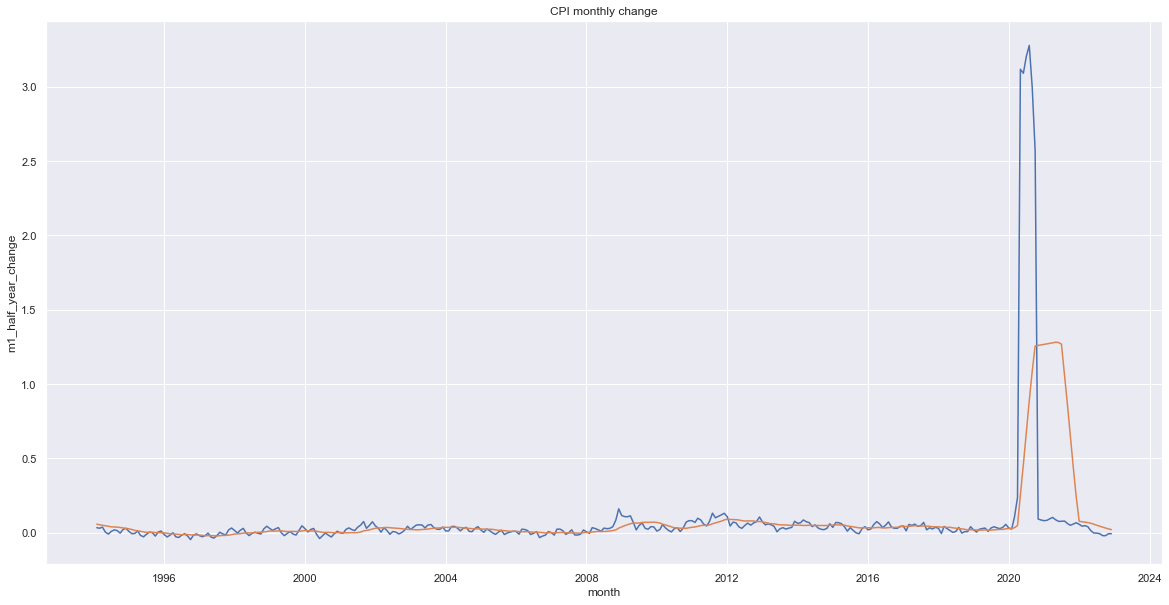

In [54]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="m1_half_year_change")
sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="m1_half_year_sma")
ax.set(title="CPI monthly change")
plt.show()

#### Yearly

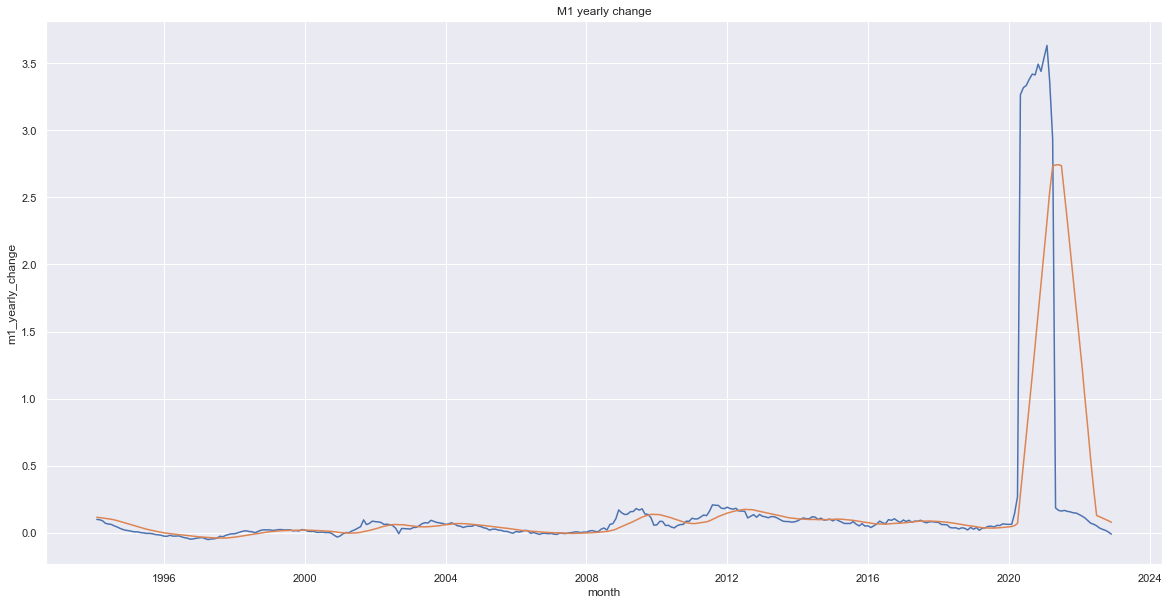

In [55]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="m1_yearly_change")
sns.lineplot(data=df_inflation.query('month > "Jan 1994"'), x="month", y="m1_yearly_sma")
ax.set(title="M1 yearly change")
plt.show()

### Distribution

In [56]:
df_inflation

,month,M1,Year,month_raw,CPI,M2,cpi_monthy_change,m1_monthy_change,m2_monthy_change,cpi_monthy_sma,...,m2_half_year_change,cpi_half_year_sma,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma
0,1913-01-01,NaN,1913,Jan,9.800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1913-02-01,NaN,1913,Feb,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1913-03-01,NaN,1913,Mar,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1913-04-01,NaN,1913,Apr,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1913-05-01,NaN,1913,May,9.700,NaN,-0.010204,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2022-08-01,20380.2,2022,Aug,296.171,21625.3,-0.000354,-0.00447,-0.001247,0.006396,...,0.001612,0.041952,0.043250,0.038186,0.082627,0.035385,0.040779,0.072031,0.119461,0.100705
1316,2022-09-01,NaN,2022,Sep,NaN,NaN,0.000000,0.00000,0.000000,0.005777,...,-0.010546,0.041090,0.036847,0.033352,0.079695,0.025460,0.031845,0.073750,0.110013,0.094222
1317,2022-10-01,NaN,2022,Oct,NaN,NaN,0.000000,0.00000,0.000000,0.005456,...,-0.010750,0.039807,0.030379,0.028505,0.070798,0.017941,0.024993,0.074893,0.100409,0.087417
1318,2022-11-01,NaN,2022,Nov,NaN,NaN,0.000000,0.00000,0.000000,0.005319,...,0.001616,0.038016,0.024683,0.024331,0.065563,0.005566,0.013626,0.075763,0.089657,0.079378


<AxesSubplot:xlabel='cpi_monthy_change', ylabel='Density'>

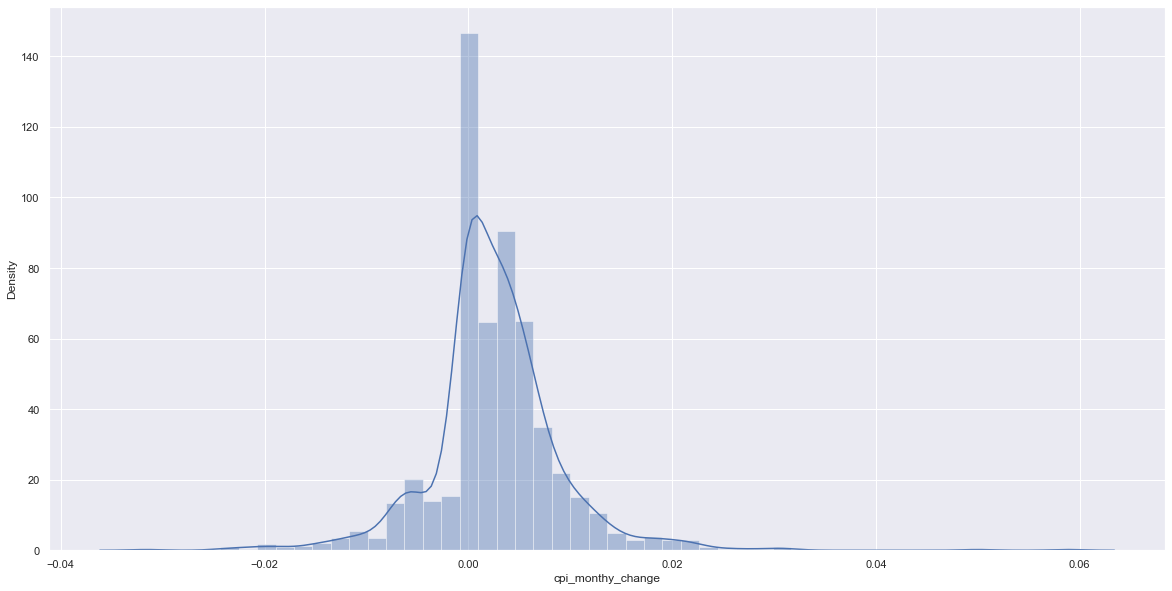

In [57]:
sns.distplot(df_inflation['cpi_monthy_change'])

<AxesSubplot:xlabel='cpi_yearly_change', ylabel='Density'>

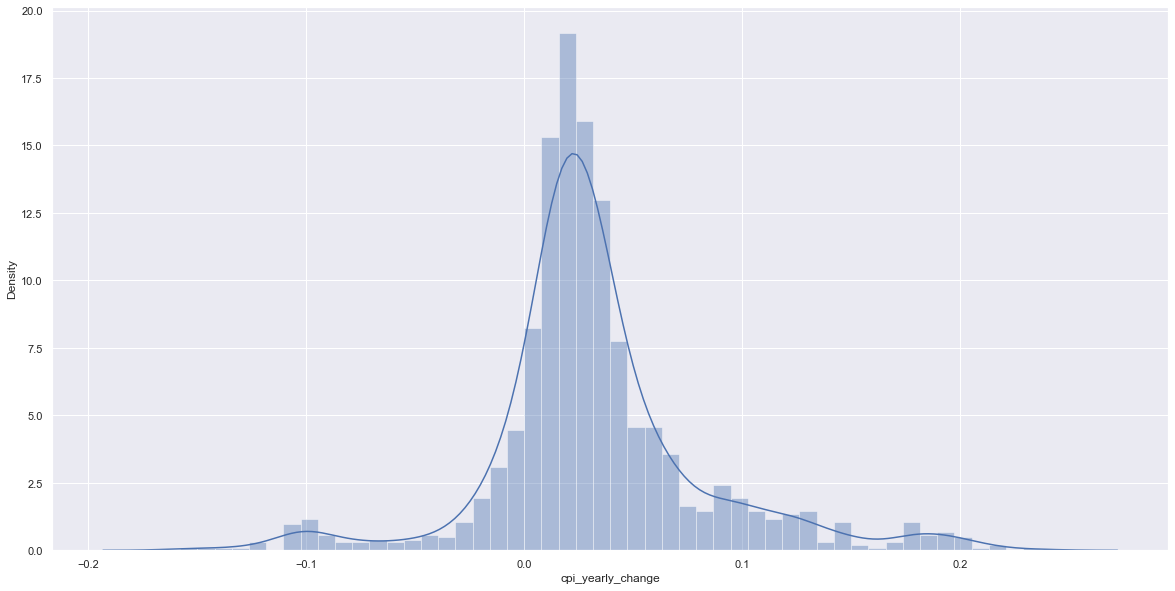

In [58]:
sns.distplot(df_inflation['cpi_yearly_change'])

In [59]:
df_inflation['cpi_yearly_change'].describe()

count    1308.000000
mean        0.032734
std         0.049571
min        -0.157895
25%         0.011944
50%         0.026369
75%         0.046581
max         0.236686
Name: cpi_yearly_change, dtype: float64

In [60]:
(1+df_inflation['cpi_yearly_change'].mean())**20

1.9044479456472099

In [61]:
df_inflation

,month,M1,Year,month_raw,CPI,M2,cpi_monthy_change,m1_monthy_change,m2_monthy_change,cpi_monthy_sma,...,m2_half_year_change,cpi_half_year_sma,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma
0,1913-01-01,NaN,1913,Jan,9.800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1913-02-01,NaN,1913,Feb,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1913-03-01,NaN,1913,Mar,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1913-04-01,NaN,1913,Apr,9.800,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1913-05-01,NaN,1913,May,9.700,NaN,-0.010204,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2022-08-01,20380.2,2022,Aug,296.171,21625.3,-0.000354,-0.00447,-0.001247,0.006396,...,0.001612,0.041952,0.043250,0.038186,0.082627,0.035385,0.040779,0.072031,0.119461,0.100705
1316,2022-09-01,NaN,2022,Sep,NaN,NaN,0.000000,0.00000,0.000000,0.005777,...,-0.010546,0.041090,0.036847,0.033352,0.079695,0.025460,0.031845,0.073750,0.110013,0.094222
1317,2022-10-01,NaN,2022,Oct,NaN,NaN,0.000000,0.00000,0.000000,0.005456,...,-0.010750,0.039807,0.030379,0.028505,0.070798,0.017941,0.024993,0.074893,0.100409,0.087417
1318,2022-11-01,NaN,2022,Nov,NaN,NaN,0.000000,0.00000,0.000000,0.005319,...,0.001616,0.038016,0.024683,0.024331,0.065563,0.005566,0.013626,0.075763,0.089657,0.079378


In [62]:
months_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

<AxesSubplot:xlabel='month_raw', ylabel='cpi_monthy_change'>

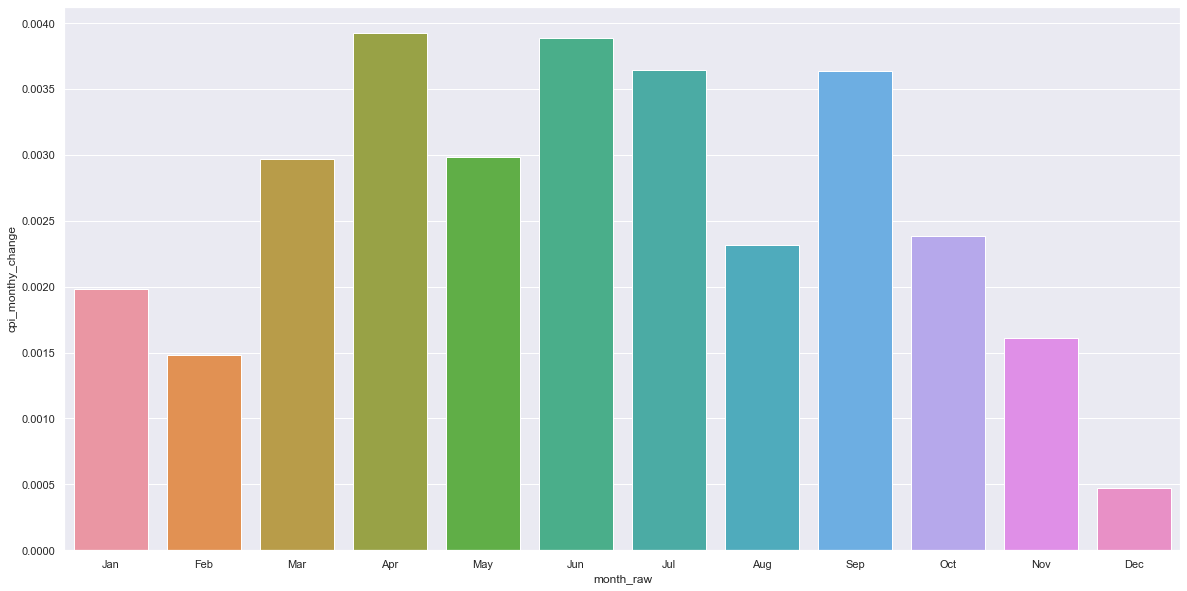

In [63]:
df_temp = df_inflation.groupby('month_raw').agg({"cpi_monthy_change" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
sns.barplot(data=df_temp, x='month_raw', y='cpi_monthy_change')

<AxesSubplot:xlabel='month_raw', ylabel='m1_monthy_change'>

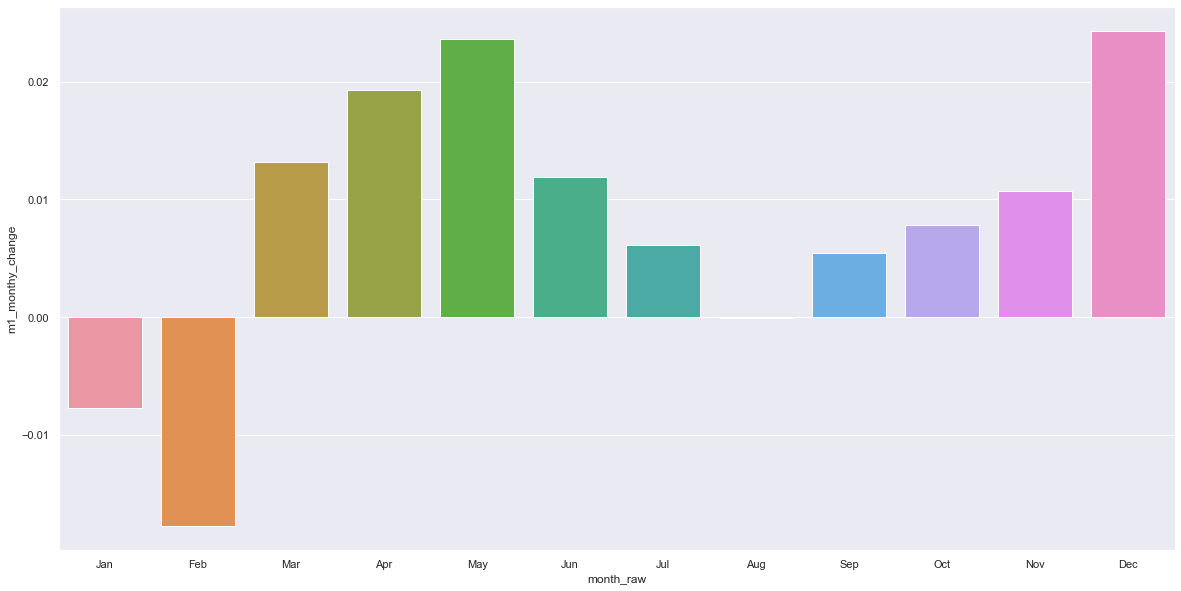

In [64]:
df_temp = df_inflation.groupby('month_raw').agg({"m1_monthy_change" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
sns.barplot(data=df_temp, x='month_raw', y='m1_monthy_change')

In [65]:
df_temp

,month_raw,m1_monthy_change
4,Jan,-0.007686
3,Feb,-0.017704
7,Mar,0.013137
0,Apr,0.019310
8,May,0.023647
6,Jun,0.011893
5,Jul,0.006102
1,Aug,-0.000095
11,Sep,0.005481
10,Oct,0.007784


### relationship between the measures

In [66]:
df_inflation_time_filtered = df_inflation.query('month >= "Jan 1994" and month <= "Jan 2012"')

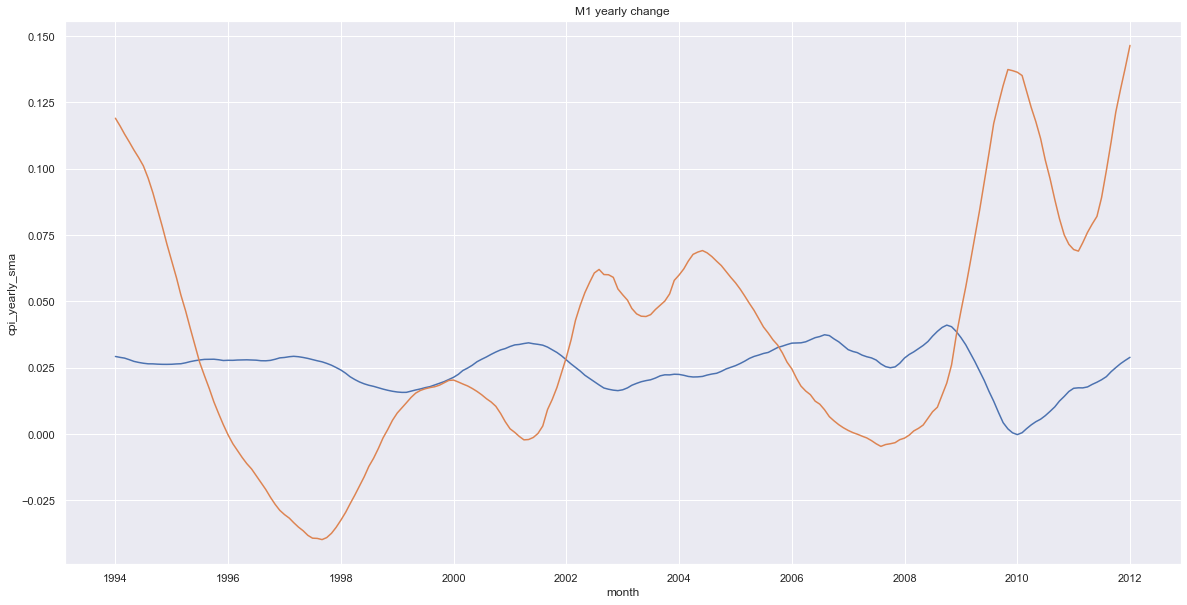

In [67]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = plt.subplot()
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_change")
sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_sma")
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="m1_yearly_change")
sns.lineplot(data=df_inflation_time_filtered.shift(0), x="month", y="m1_yearly_sma")
ax.set(title="M1 yearly change")
plt.show()

In [68]:
df_inflation_time_filtered['m1_yearly_sma_shift'] = df_inflation_time_filtered['m1_yearly_sma'].shift(24)*0.25

In [69]:
df_inflation_time_filtered['m1_yearly_change_shift'] = df_inflation_time_filtered['m1_yearly_change'].shift(24) * 0.2

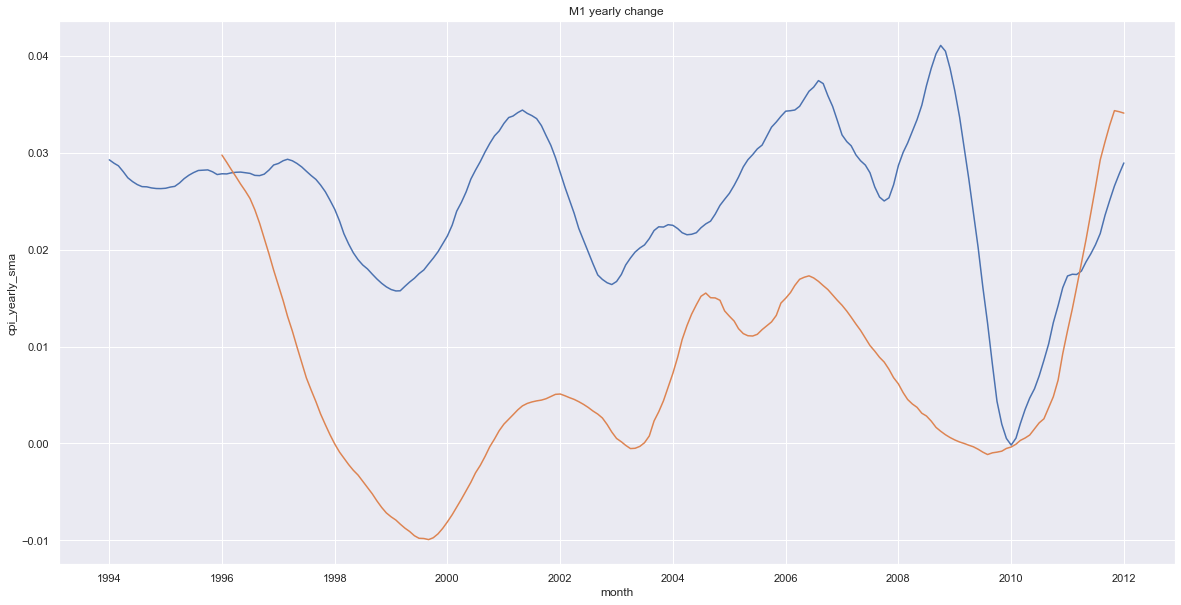

In [70]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = plt.subplot()
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_change")
sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_sma")
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="m1_yearly_change")
sns.lineplot(data=df_inflation_time_filtered.shift(0).reset_index(), x="month", y="m1_yearly_sma_shift")
ax.set(title="M1 yearly change")
plt.show()

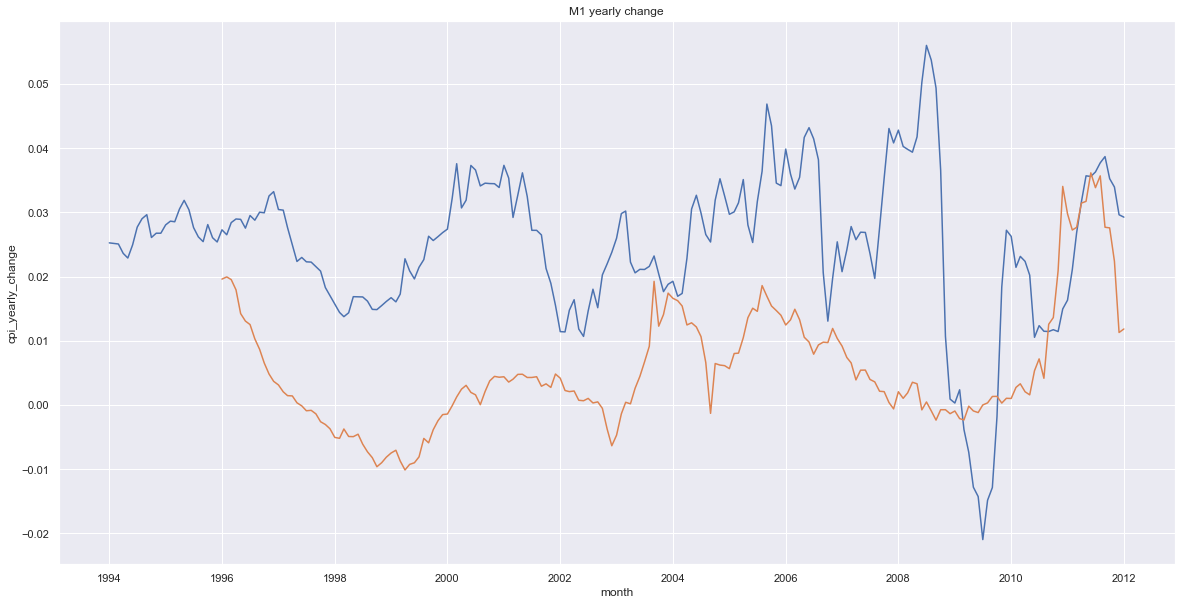

In [71]:
sns.set(rc = {'figure.figsize':(20,10)})
ax = plt.subplot()
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_change")
sns.lineplot(data=df_inflation_time_filtered, x="month", y="cpi_yearly_change")
# sns.lineplot(data=df_inflation_time_filtered, x="month", y="m1_yearly_change")
sns.lineplot(data=df_inflation_time_filtered.shift(0).reset_index(), x="month", y="m1_yearly_change_shift")
ax.set(title="M1 yearly change")
plt.show()

We see graphically that the CPI change correlates heavily with the M1 change 2 years delayed

In [72]:
df_inflation_time_filtered.corr()['cpi_yearly_sma']['m1_yearly_sma_shift']

0.33359907636433056

In [73]:
df_inflation_time_filtered

,month,M1,Year,month_raw,CPI,M2,cpi_monthy_change,m1_monthy_change,m2_monthy_change,cpi_monthy_sma,...,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma,m1_yearly_sma_shift,m1_yearly_change_shift
972,1994-01-01,1141.7,1994,Jan,146.200,3480.1,0.002743,-0.010058,-0.004292,0.002041,...,0.060289,0.007828,0.025245,0.098000,0.016503,0.029277,0.119057,0.011657,NaN,NaN
973,1994-02-01,1123.8,1994,Feb,146.700,3459.7,0.003420,-0.015678,-0.005862,0.002174,...,0.056926,0.007299,0.025157,0.099716,0.017349,0.028922,0.116059,0.011584,NaN,NaN
974,1994-03-01,1131.1,1994,Mar,147.200,3477.2,0.003408,0.006496,0.005058,0.002449,...,0.052254,0.006917,0.025070,0.097623,0.019557,0.028660,0.113102,0.011807,NaN,NaN
975,1994-04-01,1152.2,1994,Apr,147.400,3503.1,0.001359,0.018654,0.007449,0.002210,...,0.049297,0.007293,0.023611,0.089654,0.021193,0.028062,0.110102,0.012424,NaN,NaN
976,1994-05-01,1132.0,1994,May,147.500,3474.5,0.000678,-0.017532,-0.008164,0.002022,...,0.045915,0.007206,0.022885,0.071158,0.014453,0.027423,0.107065,0.013179,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,2011-09-01,2099.1,2011,Sep,226.889,9500.3,0.001518,-0.001332,0.004069,0.002683,...,0.065552,0.031118,0.038684,0.205409,0.098364,0.023546,0.110184,0.050678,0.031135,0.027680
1185,2011-10-01,2128.1,2011,Oct,226.421,9550.1,-0.002063,0.013815,0.005242,0.002531,...,0.071095,0.033873,0.035252,0.204085,0.096402,0.025072,0.121345,0.055763,0.032836,0.027581
1186,2011-11-01,2164.4,2011,Nov,226.230,9633.1,-0.000844,0.017057,0.008691,0.002383,...,0.076877,0.037582,0.033944,0.183573,0.097727,0.026570,0.130018,0.060521,0.034355,0.022382
1187,2011-12-01,2208.1,2011,Dec,225.672,9729.2,-0.002467,0.020190,0.009976,0.002179,...,0.085084,0.041516,0.029624,0.179919,0.098401,0.027782,0.137934,0.065059,0.034249,0.011285


In [74]:
df_inflation_time_filtered.corr()['cpi_yearly_change']['m1_yearly_sma_shift']

0.34220350469764815

While linearry the correlation is weaker than expected, graphically we see heavy correlation

## Feature engineering

First let's decide what our target is.  
As the rule of thumb the CPI only increases and not necessary lineary, as well as usually after a large spike it doesn't bounce back to where it was, it would be difficult to predict the CPI itself.  
However, we can predict how much it would increase.

so our target will be the next cpi_yearly_change

In [75]:
df_inflation['target'] = df_inflation['cpi_monthy_change'].shift(-1)

In [76]:
df_inflation = df_inflation.dropna()

In [77]:
df_inflation['month_num'] = df_inflation['month'].dt.month

In [78]:
df_inflation = df_inflation.set_index('month')

In [79]:
df_inflation = df_inflation.drop(['Year', 'month_raw'], axis=1)

In [80]:
df_inflation

,M1,CPI,M2,cpi_monthy_change,m1_monthy_change,m2_monthy_change,cpi_monthy_sma,m1_monthy_sma,m2_monthy_sma,cpi_quarterly_change,...,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma,target,month_num
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,140.6,29.800,317.2,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.004076,0.023856,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3
1961-04-01,142.4,29.800,320.2,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.003217,0.024464,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4
1961-05-01,140.6,29.800,320.0,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.002516,0.025403,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5
1961-06-01,141.2,29.800,322.7,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.001849,0.026495,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6
1961-07-01,141.5,30.000,324.9,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.000939,0.027285,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,20817.8,289.109,21860.3,0.005583,0.000812,0.000206,0.006697,0.009451,0.008110,0.028316,...,0.067510,0.057051,0.082586,0.090765,0.078456,0.058044,0.779073,0.142411,0.011024,4
2022-05-01,20537.9,292.296,21590.4,0.011024,-0.013445,-0.012347,0.007067,0.007897,0.006764,0.030242,...,0.062889,0.053466,0.085815,0.071367,0.062541,0.062648,0.541628,0.128635,0.013736,5
2022-06-01,20535.4,296.311,21645.0,0.013736,-0.000122,0.002529,0.007510,0.006218,0.005490,0.030633,...,0.056544,0.048374,0.090598,0.063437,0.058917,0.066941,0.321594,0.116411,-0.000118,6


In [81]:
df_inflation = df_inflation[:-10]

In [82]:
df_inflation

,M1,CPI,M2,cpi_monthy_change,m1_monthy_change,m2_monthy_change,cpi_monthy_sma,m1_monthy_sma,m2_monthy_sma,cpi_quarterly_change,...,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma,target,month_num
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,140.6,29.800,317.2,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.004076,0.023856,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3
1961-04-01,142.4,29.800,320.2,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.003217,0.024464,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4
1961-05-01,140.6,29.800,320.0,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.002516,0.025403,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5
1961-06-01,141.2,29.800,322.7,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.001849,0.026495,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6
1961-07-01,141.5,30.000,324.9,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.000939,0.027285,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,19310.4,271.696,20440.7,0.009291,0.007334,0.005960,0.003433,0.176196,0.016346,0.025744,...,1.279340,0.109733,0.053915,0.167179,0.129090,0.019145,2.743747,0.218225,0.004811,6
2021-07-01,19459.4,273.003,20571.9,0.004811,0.007716,0.006419,0.004199,0.167984,0.012429,0.022276,...,1.268668,0.105083,0.053655,0.162005,0.127054,0.022503,2.736630,0.215392,0.002066,7
2021-08-01,19683.7,273.567,20778.0,0.002066,0.011527,0.010019,0.004336,0.013211,0.010507,0.016241,...,1.065934,0.098410,0.052513,0.166849,0.134220,0.025925,2.530072,0.209740,0.002716,8


### Logorithmic transformation
As some features are growing exponentially (e.g. CPI, M1),  
it would be wiser to apply a log function to the feature, as linear models work less well with exponential data

In [83]:
df_inflation['M1'] = np.log(df_inflation['M1'])
df_inflation['M2'] = np.log(df_inflation['M2'])
df_inflation['CPI'] = np.log(df_inflation['CPI'])

In [84]:
df_inflation

,M1,CPI,M2,cpi_monthy_change,m1_monthy_change,m2_monthy_change,cpi_monthy_sma,m1_monthy_sma,m2_monthy_sma,cpi_quarterly_change,...,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma,target,month_num
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,4.945919,3.394508,5.759532,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.004076,0.023856,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3
1961-04-01,4.958640,3.394508,5.768946,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.003217,0.024464,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4
1961-05-01,4.945919,3.394508,5.768321,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.002516,0.025403,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5
1961-06-01,4.950177,3.394508,5.776723,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.001849,0.026495,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6
1961-07-01,4.952300,3.401197,5.783517,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.000939,0.027285,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,9.868399,5.604684,9.925283,0.009291,0.007334,0.005960,0.003433,0.176196,0.016346,0.025744,...,1.279340,0.109733,0.053915,0.167179,0.129090,0.019145,2.743747,0.218225,0.004811,6
2021-07-01,9.876086,5.609483,9.931681,0.004811,0.007716,0.006419,0.004199,0.167984,0.012429,0.022276,...,1.268668,0.105083,0.053655,0.162005,0.127054,0.022503,2.736630,0.215392,0.002066,7
2021-08-01,9.887546,5.611547,9.941650,0.002066,0.011527,0.010019,0.004336,0.013211,0.010507,0.016241,...,1.065934,0.098410,0.052513,0.166849,0.134220,0.025925,2.530072,0.209740,0.002716,8


## Train-test split

In [85]:
df_train = df_inflation[:-60]

In [86]:
df_test = df_inflation[-60:]

In [87]:
X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

In [88]:
y_train = df_train['target']
y_test = df_test['target']

## Model Training

### Baseline

In [89]:
model_linreg = LinearRegression()

In [90]:
model_linreg.fit(X_train, y_train)

LinearRegression()

In [91]:
model_linreg.score(X_test, y_test)

-38.041285711721756

In [92]:
y_pred_linreg = model_linreg.predict(X_test)

In [93]:
y_pred_linreg

array([-1.46822393e-03,  1.12237299e-03,  5.81182456e-03,  3.35479485e-03,
        2.86540268e-03,  3.53360011e-03,  3.60951983e-03,  9.96646511e-04,
        1.06362535e-03,  3.10082391e-03,  1.39457297e-03, -9.98823923e-06,
       -2.27602840e-04,  4.47760528e-04,  5.71292001e-03,  2.83172931e-03,
        3.55574461e-03,  4.32361627e-03,  4.30924106e-03,  8.43059676e-04,
        2.06867919e-03,  2.32203615e-03,  1.06081438e-03,  1.74125394e-03,
       -1.30695710e-03,  3.16229287e-05,  4.01638493e-03,  3.46766744e-03,
        3.40945885e-03,  5.18878767e-03,  2.56843576e-03, -3.67846434e-04,
        1.63774843e-03,  7.14951286e-04,  4.81703446e-04,  1.01767546e-03,
       -2.02028078e-04,  1.38916705e-03,  4.73694227e-03,  3.52785790e-03,
       -3.83063622e-04, -1.29126476e-03,  8.22982853e-02, -1.52575784e-02,
        1.32062866e-02,  1.05589546e-03, -1.98526078e-02, -3.65980709e-02,
       -3.53870442e-02, -3.18615064e-02, -2.86332139e-02, -2.89119073e-02,
       -2.20695025e-02, -

In [94]:
y_test

month
2016-11-01    0.000327
2016-12-01    0.005828
2017-01-01    0.003146
2017-02-01    0.000813
2017-03-01    0.002966
2017-04-01    0.000855
2017-05-01    0.000907
2017-06-01   -0.000690
2017-07-01    0.002994
2017-08-01    0.005295
2017-09-01   -0.000632
2017-10-01    0.000024
2017-11-01   -0.000588
2017-12-01    0.005448
2018-01-01    0.004535
2018-02-01    0.002261
2018-03-01    0.003975
2018-04-01    0.004159
2018-05-01    0.001594
2018-06-01    0.000067
2018-07-01    0.000556
2018-08-01    0.001162
2018-09-01    0.001767
2018-10-01   -0.003349
2018-11-01   -0.003194
2018-12-01    0.001907
2019-01-01    0.004227
2019-02-01    0.005641
2019-03-01    0.005295
2019-04-01    0.002129
2019-05-01    0.000199
2019-06-01    0.001671
2019-07-01   -0.000051
2019-08-01    0.000783
2019-09-01    0.002286
2019-10-01   -0.000536
2019-11-01   -0.000910
2019-12-01    0.003880
2020-01-01    0.002741
2020-02-01   -0.002176
2020-03-01   -0.006687
2020-04-01    0.000020
2020-05-01    0.005472
2020-

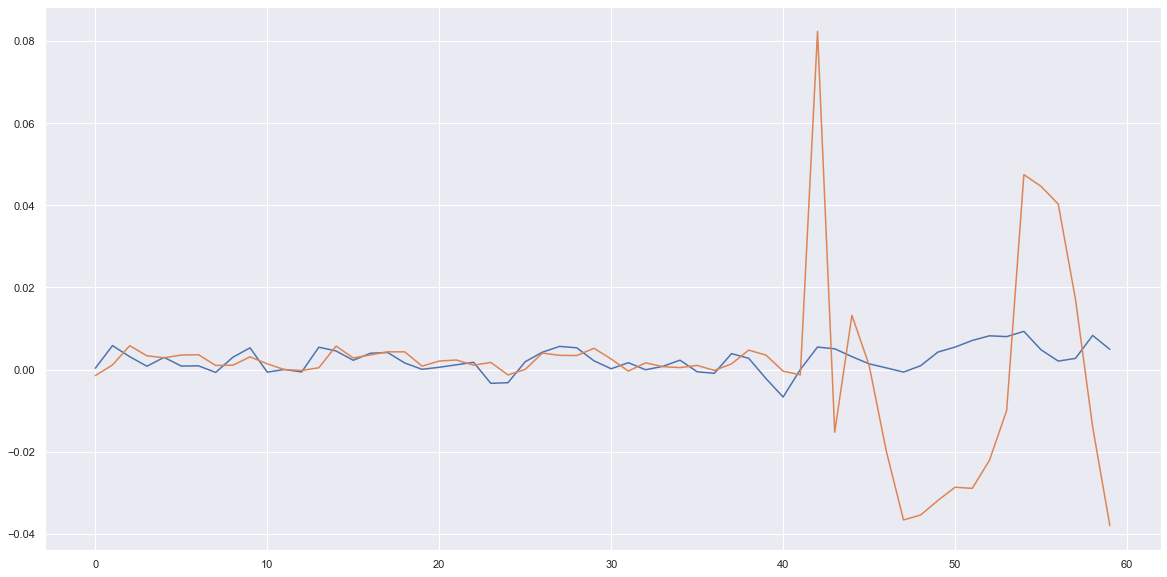

In [106]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred_linreg)

<AxesSubplot:>

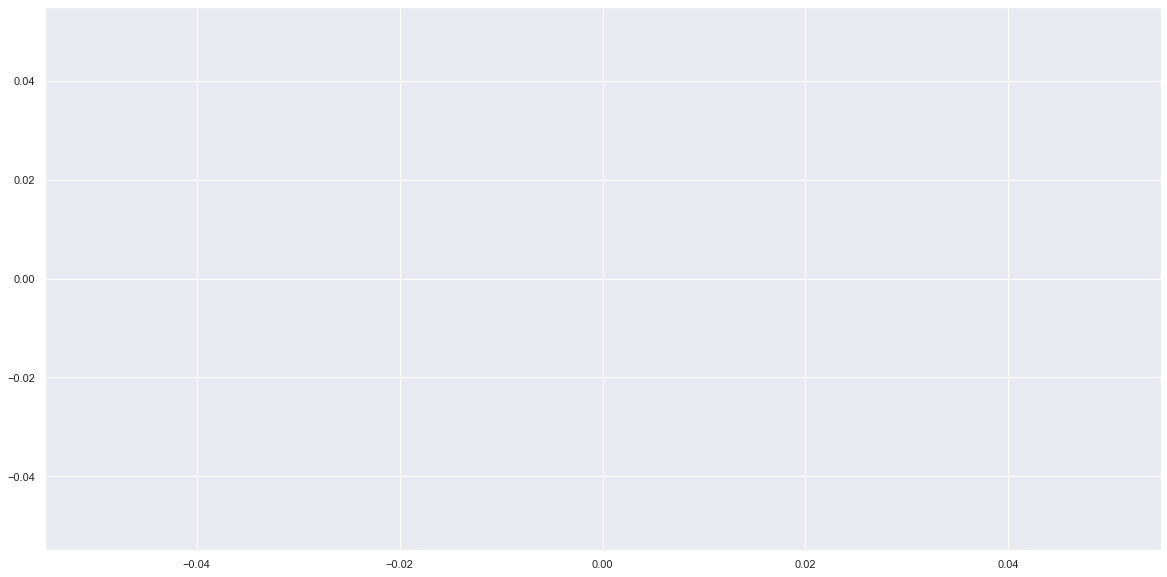

In [96]:
#sns.lineplot(y_test)
sns.lineplot(y_pred_linreg)

### CatBoost

In [100]:
model_catboost = CatBoostRegressor()

In [101]:
model_catboost.fit(X_train, y_train)

Learning rate set to 0.038414
0:	learn: 0.0035523	total: 150ms	remaining: 2m 29s
1:	learn: 0.0035014	total: 152ms	remaining: 1m 15s
2:	learn: 0.0034589	total: 153ms	remaining: 50.8s
3:	learn: 0.0034220	total: 154ms	remaining: 38.4s
4:	learn: 0.0033830	total: 155ms	remaining: 30.9s
5:	learn: 0.0033446	total: 156ms	remaining: 25.9s
6:	learn: 0.0033043	total: 158ms	remaining: 22.4s
7:	learn: 0.0032714	total: 159ms	remaining: 19.7s
8:	learn: 0.0032488	total: 160ms	remaining: 17.6s
9:	learn: 0.0032190	total: 161ms	remaining: 16s
10:	learn: 0.0031848	total: 163ms	remaining: 14.6s
11:	learn: 0.0031495	total: 164ms	remaining: 13.5s
12:	learn: 0.0031222	total: 166ms	remaining: 12.6s
13:	learn: 0.0030972	total: 167ms	remaining: 11.7s
14:	learn: 0.0030688	total: 168ms	remaining: 11s
15:	learn: 0.0030439	total: 169ms	remaining: 10.4s
16:	learn: 0.0030239	total: 171ms	remaining: 9.88s
17:	learn: 0.0029958	total: 172ms	remaining: 9.39s
18:	learn: 0.0029718	total: 187ms	remaining: 9.68s
19:	learn: 0.

In [102]:
model_catboost.score(X_test, y_test)

0.22830164742364134

In [103]:
y_pred_catboost = model_catboost.predict(X_test)

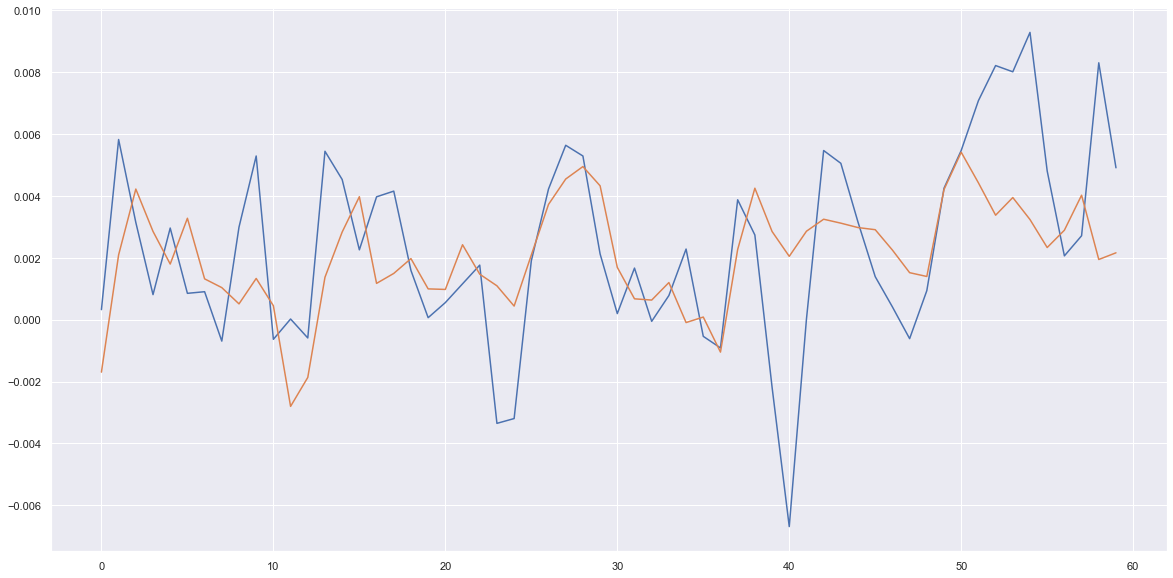

In [104]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred_catboost)